In [1]:
# Move ipynb to the root of the repo to run it correctly
# Moved here for sving purpose

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from preprocess.file_manage import load_csv
from setting.paths import TRAIN_DIR, TEST_DIR

2024-11-07 23:18:03.866454: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 23:18:03.868294: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 23:18:03.873732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731039483.883085 2280365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731039483.885805 2280365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 23:18:03.895627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
def create_dataset(X, y, n_input=3):
    '''
    Create a dataset suitable for LSTM.

    Parameters:
        X (DataFrame): The input DataFrame.
        y (DataFrame): The target DataFrame.
        n_input (int): The number of time steps to look back.

    Returns:
        TimeseriesGenerator: A generator for training the model.
    '''
    generator = TimeseriesGenerator(
        X.values, y.values, length=n_input, batch_size=1)
    return generator

In [3]:
def build_lstm_model(input_shape):
    '''
    Build and compile the LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data.

    Returns:
        model: Compiled LSTM model.
    '''
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
def plot_loss(history):
    '''
    Plot training and validation loss over epochs.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def smooth_data(data, window_size=5):
    '''
    Apply a moving average to smooth the data.

    Parameters:
        data (array-like): The input data to smooth.
        window_size (int): The size of the sliding window for the moving average.

    Returns:
        smoothed_data (array-like): The smoothed data.
    '''
    data = np.ravel(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_predictions(y_true, y_pred, window_size=5):
    '''
    Plot predicted vs actual values.
    '''

    smoothed_true = smooth_data(y_true, window_size)
    smoothed_pred = smooth_data(y_pred, window_size)

    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Traffic Flow')
    plt.plot(y_pred, label='Predicted Traffic Flow')
    plt.title('Predicted vs Actual Traffic Flow')
    plt.xlabel('Time')
    plt.ylabel('Traffic Flow')
    plt.legend()
    plt.show()

In [5]:
def main(hide=False):
    '''
    main running codes
    '''
    X_train = load_csv(f"{TRAIN_DIR}/X.csv")
    y_train = load_csv(f"{TRAIN_DIR}/y.csv")
    X_test = load_csv(f"{TEST_DIR}/X.csv")
    y_test = load_csv(f"{TEST_DIR}/y.csv")

    n_input = 3
    train_gen = create_dataset(X_train, y_train, n_input=n_input)
    test_gen = create_dataset(X_test, y_test, n_input=n_input)

    model = build_lstm_model(input_shape=(n_input, X_train.shape[1]))

    checkpoint = ModelCheckpoint(
        'LSTM_best_model.keras', save_best_only=True, monitor='loss', mode='min')

    verbose = 2 if hide is True else 0 if hide == 'Full' else 1

    history = model.fit(train_gen, epochs=200,
                        verbose=verbose, callbacks=[checkpoint])

    loss = model.evaluate(test_gen)
    print(f'Test Loss: {loss}')

    y_pred = model.predict(test_gen)

    return history, y_pred, y_test.values

In [6]:
history, yp, yt = main(hide='Full')

W0000 00:00:1731039485.150804 2280365 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jun/miniconda3/envs/traffic/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jun/miniconda3/envs/traffic/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments t

593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 3610.8696
Test Loss: 3760.741455078125
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


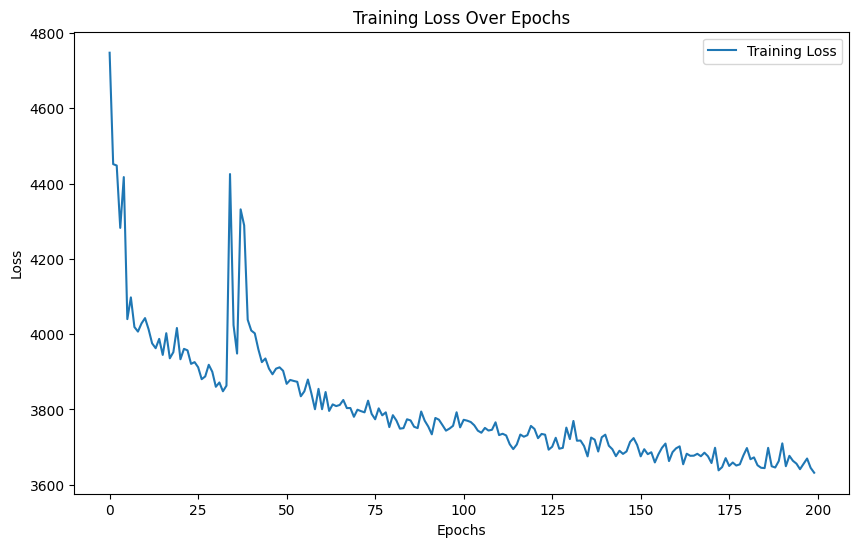

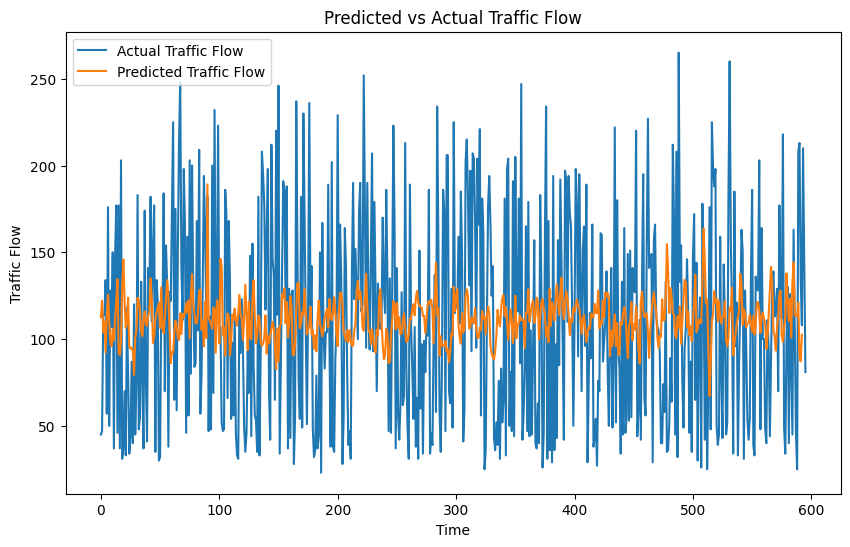

In [10]:
plot_loss(history)
plot_predictions(yt, yp)